# Cats and Dogs CNN

**Description:** Classify cats and dogs with a simple Convolutional Network<br>
                 
**Dataset:** Kaggle Dogs vs Cats dataset originally from Microsoft <br>

In [1]:
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Rescaling
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import image_dataset_from_directory

import numpy as np

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1736962170.011376    9305 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736962170.038257    9305 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736962170.038298    9305 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736962170.040263    9305 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736962170.040307    9305 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


#### **Directories**
Reads the Cats and Dogs dataset and loads in. Creating a PetImages folder with two subfolders Cat and Dog <bbr>
Don't repeat this step as with the files/folders created it may have some issues

In [ ]:
# Loading the dataset from microsoft cloud - do it only once
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   104M      0  0:00:07  0:00:07 --:--:--  107M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### **Cleaning data**
Just for security we delete some photos that may have the header corrupted.

In [2]:
num_skipped = 0
num_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_images += 1

print(f"Deleted {num_skipped} images.")
print(f"There are {num_images} clean images.")

Deleted 0 images.
There are 23412 clean images.


#### **Preparing the data**

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


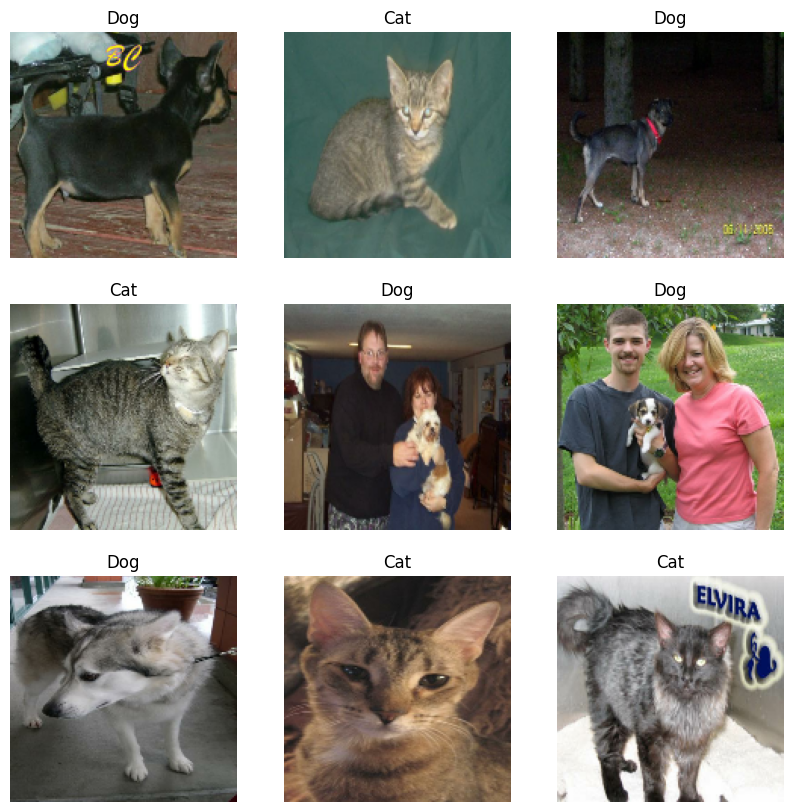

In [6]:
batch_size = 32
img_height = 150  
img_width  = 150
train_dir = './PetImages/'
class_names = ['Cat', 'Dog']

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
        
# Optional: Normalize pixel values (0-255 to 0-1)
normalization_layer = Rescaling(1./255)

train_dataset        = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset   = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

#### **Network Architecture Definition**

In [7]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# training the network

In [9]:
history = model.fit(
      train_dataset,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_dataset,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 9s - 92ms/step - acc: 0.5428 - loss: 0.7199 - val_acc: 0.6356 - val_loss: 0.6625
Epoch 2/30
100/100 - 2s - 23ms/step - acc: 0.6169 - loss: 0.6621 - val_acc: 0.6413 - val_loss: 0.6310
Epoch 3/30
100/100 - 3s - 29ms/step - acc: 0.6697 - loss: 0.6225 - val_acc: 0.6923 - val_loss: 0.5758
Epoch 4/30
100/100 - 2s - 17ms/step - acc: 0.6869 - loss: 0.5981 - val_acc: 0.6944 - val_loss: 0.5668
Epoch 5/30
100/100 - 2s - 23ms/step - acc: 0.7231 - loss: 0.5520 - val_acc: 0.7069 - val_loss: 0.5549
Epoch 6/30
100/100 - 4s - 38ms/step - acc: 0.7148 - loss: 0.5556 - val_acc: 0.7200 - val_loss: 0.5433
Epoch 7/30
100/100 - 2s - 24ms/step - acc: 0.7328 - loss: 0.5205 - val_acc: 0.7506 - val_loss: 0.5042
Epoch 8/30
100/100 - 2s - 23ms/step - acc: 0.7378 - loss: 0.5235 - val_acc: 0.6281 - val_loss: 0.7139
Epoch 9/30
100/100 - 2s - 23ms/step - acc: 0.7541 - loss: 0.5035 - val_acc: 0.7497 - val_loss: 0.4904
Epoch 10/30
100/100 - 2s - 24ms/step - acc: 0.7591 - loss: 0.4990 - val_acc: 0.765

#### **Evaluate the Results**

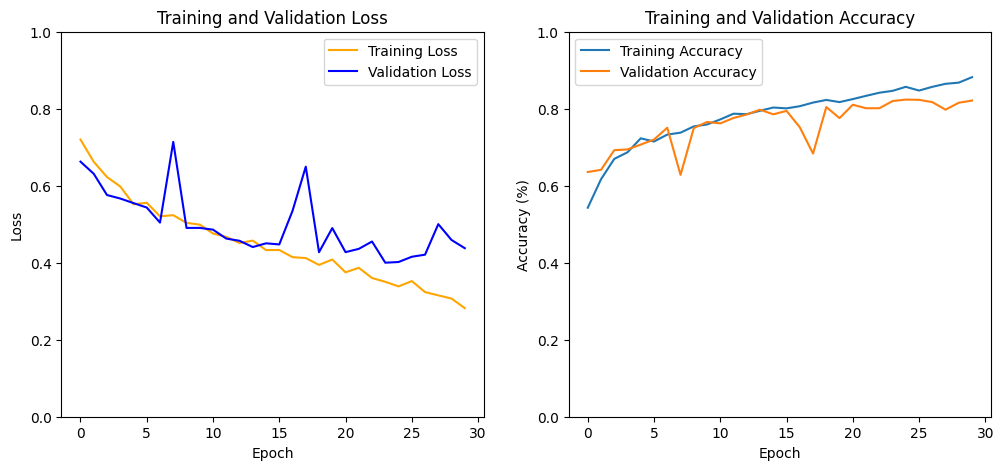

In [30]:
# Plot training loss, accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


#### **Generate Confusion Matrix**

In [21]:
# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images, verbose=0)  # Model predictions
    y_pred.extend((preds > 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

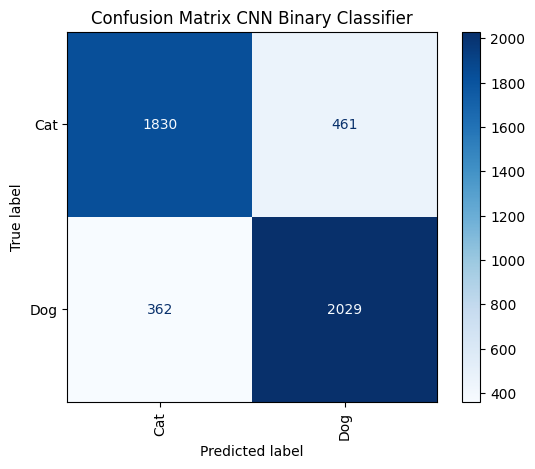

In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix CNN Binary Classifier")
plt.show()

In [ ]:
# Final accuracy
print('final accuracy test:', acc[-1])
print('final accuracy validation', val_acc[-1])

In [27]:
import session_info
session_info.show(html=False)

-----
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
sklearn             1.5.2
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-01-15 18:49
